In [2]:
#import some python libraries
import csv, glob, os, sys, numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import timeit
from scipy.optimize import curve_fit
from scipy import optimize
from scipy.interpolate import griddata
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from scipy import signal
from numpy import NaN, Inf, arange, isscalar, asarray, array
import numpy.polynomial.polynomial as poly
import timeit

plt.rcParams['xtick.labelsize'] = 15; plt.rcParams['ytick.labelsize'] = 15 #make size of axis tick labels larger

# IMPORT FREQUENCY DOMAIMN DATA FILE #################################################################
ffile = 'C:\\Users\\a6q\\Desktop\\CorrEL noise measurements\\m-swcnt o2 dark noise 2017-07-11.txt' #frequency filename
rawfdata = pd.read_table(ffile, skiprows=83, header=0, error_bad_lines=False, sep='\s+') #read in file
#####################################################################################################
floatdata = rawfdata.apply(pd.to_numeric, errors='coerce') #change from string to float, coercing to NaN 
fdata  = floatdata.dropna()

print(fdata)

b'Skipping line 4307: expected 4 fields, saw 7\n'
C:\Users\a6q\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


      Frequency/Hz  volt.noise/V  curr.noise/A   pow.noise/W
0           0.0000  3.380000e-03  7.690000e-04  2.600000e-06
1           0.0005  3.380000e-03  7.690000e-04  2.600000e-06
2           0.0010  4.960000e-05  7.260000e-06  3.600000e-10
3           0.0015  2.300000e-05  3.330000e-06  7.650000e-11
4           0.0020  1.990000e-05  2.910000e-06  5.790000e-11
5           0.0025  6.140000e-06  8.510000e-07  5.220000e-12
6           0.0030  1.780000e-05  2.610000e-06  4.650000e-11
7           0.0035  1.400000e-05  2.020000e-06  2.820000e-11
8           0.0040  1.460000e-05  2.160000e-06  3.160000e-11
9           0.0045  9.920000e-07  2.170000e-07  2.150000e-13
10          0.0050  1.290000e-05  1.890000e-06  2.440000e-11
11          0.0055  8.840000e-06  1.300000e-06  1.150000e-11
12          0.0060  5.260000e-06  7.870000e-07  4.140000e-12
13          0.0065  4.810000e-06  6.940000e-07  3.340000e-12
14          0.0070  4.360000e-06  6.000000e-07  2.620000e-12
15          0.0075  3.67

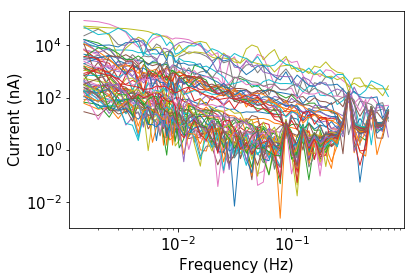

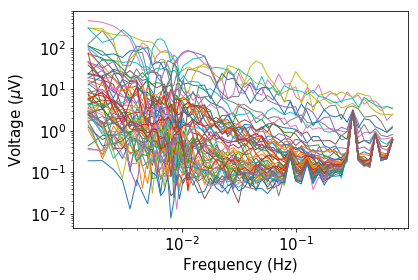

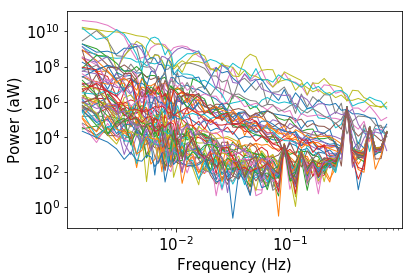

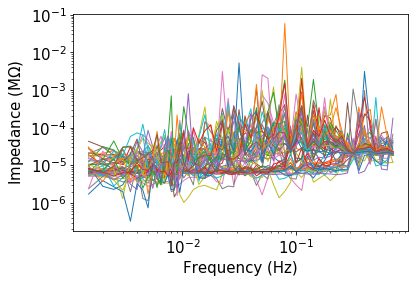

In [3]:
#convert columns into numpy arrays:
allf = np.array(fdata['Frequency/Hz']) #frequency in Hz
allv = np.array(fdata['volt.noise/V'])*1e6 #voltage in microVolts
alli = np.array(fdata['curr.noise/A'])*1e9 #current in nanoAmps
allp = np.array(fdata['pow.noise/W'])*1e18 #power in attoWatts

#calculate other quantities:
allz = np.divide(np.array(fdata['volt.noise/V']), np.array(fdata['curr.noise/A']))*1e-6 #impedance in MegaOhms

fsweep = []; i=0
while allf[i+1] > allf[i]: fsweep.append(allf[i]); i=i+1 #find length of each freq sweep

#reshape into matrices to separate each individual frequency sweep
fmat0 = np.reshape(allf, (-1,len(fsweep)+1)); imat0 = np.reshape(alli, (-1,len(fsweep)+1))
vmat0 = np.reshape(allv, (-1,len(fsweep)+1)); pmat0 = np.reshape(allp, (-1,len(fsweep)+1))
zmat0 = np.reshape(allz, (-1,len(fsweep)+1))

#set starting/ending indices to remove first 1 or 2 errant points from 0 Hz freq. measurements###################
si = 3 ; ei = 3
########################################################################################################
#new empty matrices without first/last couple points
fmat = np.ones((np.shape(fmat0)[0],np.shape(fmat0)[1]-si-ei));
vmat=np.copy(fmat); imat=np.copy(fmat); pmat=np.copy(fmat); zmat=np.copy(fmat)

for i in range(len(fmat)): #create matrices without the first/last couple points
    fmat[i] = fmat0[i][si:-ei]
    vmat[i] = vmat0[i][si:-ei]
    imat[i] = imat0[i][si:-ei]
    pmat[i] = pmat0[i][si:-ei]
    zmat[i] = zmat0[i][si:-ei]

yvars = [imat, vmat, pmat, zmat] #make lists for looping over plots
ylabels = ['Current (nA)', 'Voltage ($\mu$V)', 'Power (aW)', 'Impedance (M$\Omega$)']

for j in range(len(ylabels)):    
    for i in range(len(fmat)):
        plt.loglog(fmat[i],yvars[j][i], linewidth=1) #plot noise
    plt.xlabel('Frequency (Hz)',fontsize=15); plt.ylabel(ylabels[j],fontsize=15); plt.show()

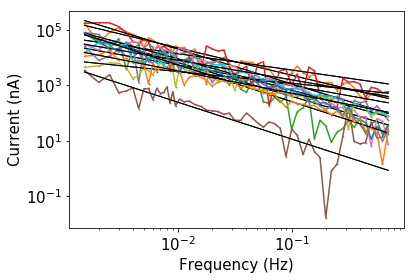

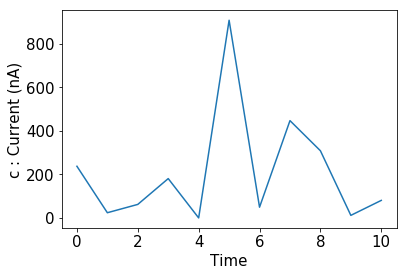

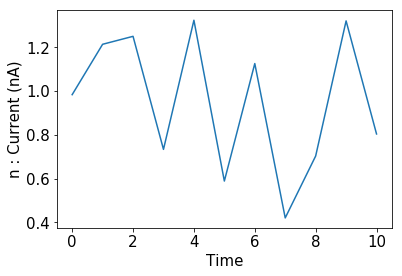

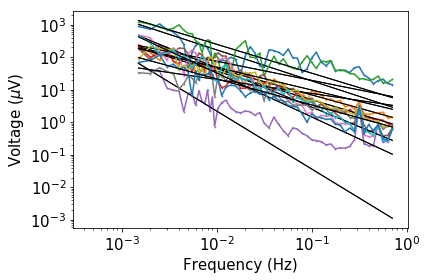

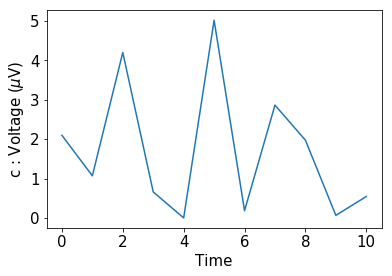

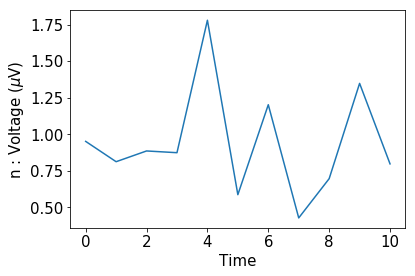

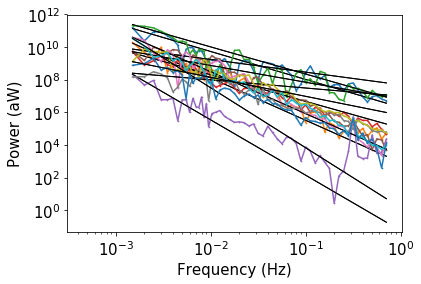

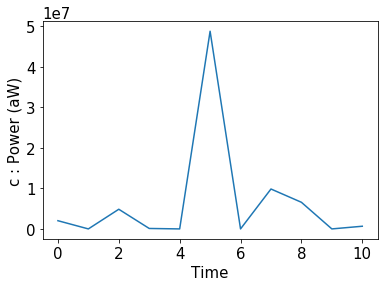

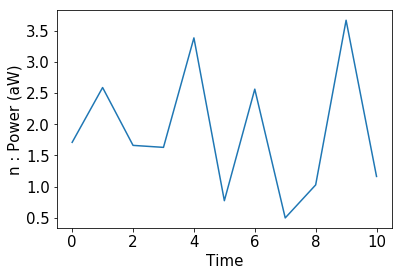

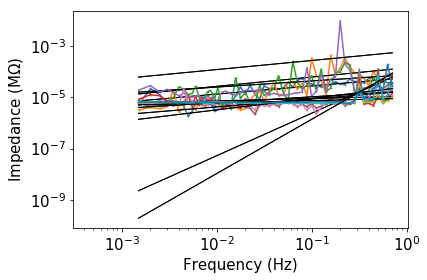

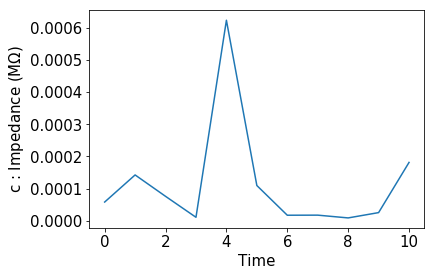

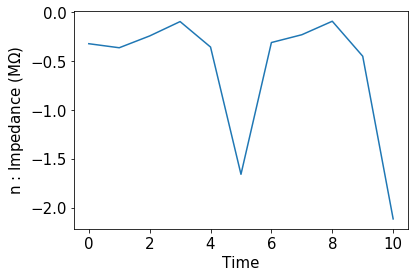

In [920]:
#fit noise to pink (1/f) or brown (1/f^2)

timecycle = np.arange(len(fmat))

yvars = [imat, vmat, pmat, zmat] #make lists for looping over plots
ylabels = ['Current (nA)', 'Voltage ($\mu$V)', 'Power (aW)', 'Impedance (M$\Omega$)']

def noisefit(f, c, n):  # define variables in each function
    return c / f**n

for k in range(len(yvars)): #loop over varibles (current, power, impedance)
    
    clist = []; nlist = [] #save lists of fitting parameters
    
    for i in range(len(fmat)): #loop over number of timing cycles
        try:
            popt, pcov = curve_fit(noisefit, fmat[i], yvars[k][i]) #find fit parameters
            fit =  noisefit(fmat[i], *popt) #build fit line
            c = popt[0]; n = popt[1] #get fitting parameters from popt
            clist.append(c); nlist.append(n)
    
            plt.scatter(fmat[i],yvars[k][i], s=.5) #plot fits
            plt.plot(fmat[i],fit,linewidth=1, c='k')
        
            plt.loglog(fmat[i],yvars[k][i]) #plot fits
            plt.loglog(fmat[i],fit,linewidth=1, c='k')
        
        
        except RuntimeError: #if error in fitting, keep going amnd assign 0 values
            clist.append(0); nlist.append(0)
            print('error in fitting column index ' + format(i))

    plt.xlabel('Frequency (Hz)',fontsize=15); plt.ylabel(ylabels[k],fontsize=15);
    plt.show()

    plt.plot(timecycle,clist)
    plt.xlabel('Time',fontsize=15); plt.ylabel('c : ' + ylabels[k],fontsize=15); plt.show()

    plt.plot(timecycle,nlist)
    plt.xlabel('Time',fontsize=15); plt.ylabel('n : ' + ylabels[k],fontsize=15); plt.show()


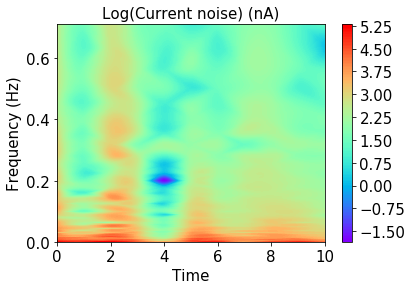

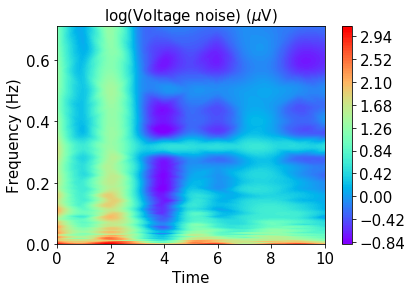

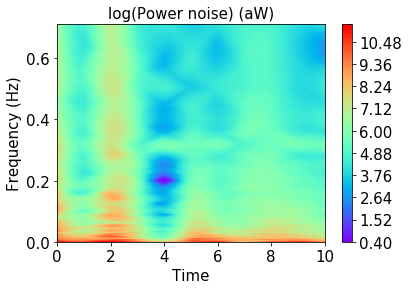

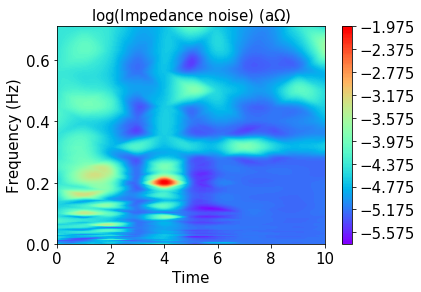

In [874]:
#plot in frequency domain over time

tmatflat = np.array([]) #make flat array of repeating "times"
for i in range(len(fmat)): tmatflat = np.append(tmatflat, np.ones(len(fmat[0]))*i)

fmatflat = fmat.flatten(); imatflat = imat.flatten()
vmatflat = vmat.flatten(); pmatflat = pmat.flatten(); zmatflat = zmat.flatten()

Zlist = [imatflat, vmatflat, pmatflat, zmatflat] #list of Z values in heatmaps

#make lists for plot titles in loop
titlenames = ['Log(Current noise) (nA)','log(Voltage noise) ($\mu$V)',
             'log(Power noise) (aW)', 'log(Impedance noise) (a$\Omega$)']

for i in range(len(Zlist)):  # plot heatmaps of time/frequency-dependent noise
    # set X, Y, and Z for plot
    X, Y, Z, = tmatflat, fmatflat, np.log10(Zlist[i]) #time, frequency, noise

    # create x-y points to be used in heatmap
    xi = np.linspace(X.min(),X.max(),1000)
    yi = np.linspace(Y.min(),Y.max(),1000)
    # Z is a matrix of x-y values
    zi = griddata((X, Y), Z, (xi[None,:], yi[:,None]), method='cubic')

    # Create the contour plot
    CS = plt.contourf(xi, yi, zi, 150, cmap=plt.cm.rainbow, vmax=np.amax(Z), vmin=np.amin(Z))
    plt.colorbar(); plt.xlabel('Time',fontsize=15); plt.ylabel('Frequency (Hz)',fontsize=15);
    plt.title(titlenames[i],fontsize=15); plt.show()

In [902]:
# IMPORT TIME-DOMAIN DATA ##########################################################################################
tfile = 'C:\\Users\\a6q\\Desktop\\SU8-ZnO\\CorrEL noise measurements\\m-swcnt time copy.txt' #frequency filename
rawtdata = pd.read_csv(ffile, skiprows=732, header=0, error_bad_lines=False, sep='\s+') #read in file
####################################################################################################################
tfloatdata = rawtdata.apply(pd.to_numeric, errors='coerce') #change from string to float, coercing to NaN 
print(tfloatdata)

       volt.noise/V  curr.noise/A
0         -0.002075     -0.000020
1         -0.000977     -0.000006
2         -0.000214     -0.000002
3         -0.000733     -0.000004
4         -0.000946     -0.000005
5         -0.001282     -0.000009
6         -0.000824     -0.000006
7         -0.001297     -0.000010
8         -0.002670     -0.000021
9         -0.003632     -0.000033
10        -0.008698     -0.000101
11        -0.007264     -0.000076
12        -0.000305     -0.000003
13        -0.000412     -0.000004
14        -0.000427     -0.000003
15        -0.000367     -0.000003
16        -0.000550     -0.000003
17        -0.000763     -0.000005
18        -0.000931     -0.000006
19        -0.000855     -0.000006
20        -0.000870     -0.000006
21        -0.000839     -0.000006
22        -0.002213     -0.000009
23        -0.005478     -0.000044
24        -0.010895     -0.000101
25        -0.011139     -0.000098
26        -0.011643     -0.000100
27        -0.011506     -0.000100
28        -0.0

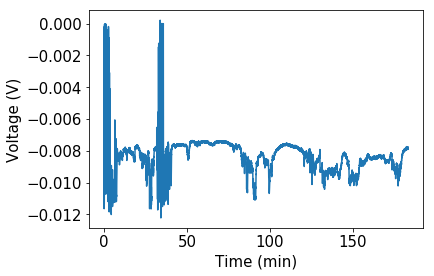

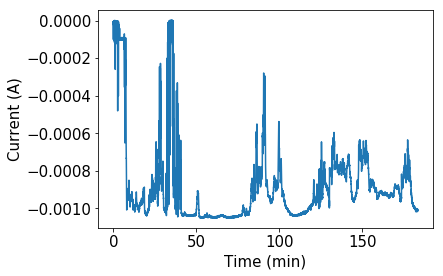

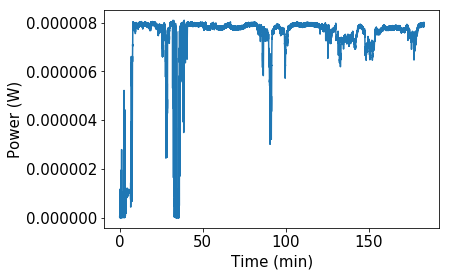

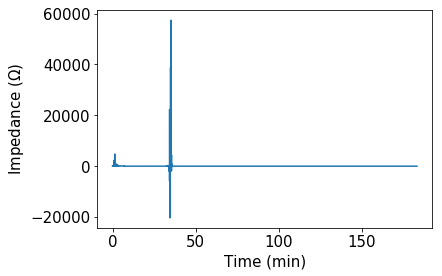

In [910]:
#ORGANIZE TIME-DOMAIN DATA

tv0 = np.array(tfloatdata['volt.noise/V']) #create voltage nad current arrays for time-domain data 
ti0 = np.array(tfloatdata['curr.noise/A'])
tp0 = np.multiply(tv0,ti0) #calculate power noise
tz0 = np.divide(tv0, ti0) #calculate impedance noise
tt0 = (np.arange(len(tvraw))*0.488)/60 #create time array in minutes

plotvars = [tv0, ti0, tp0, tz0] #create lists for looping
ylabels2 = ['Voltage (V)', 'Current (A)', 'Power (W)', 'Impedance ($\Omega$)']

for i in range(len(plotvars)): #plot
    plt.plot(tt0, plotvars[i])
    plt.xlabel('Time (min)', fontsize=15); plt.ylabel(ylabels2[i], fontsize=15)
    plt.show()

array([  0.00000000e+00,   8.13333333e-03,   1.62666667e-02, ...,
         1.83203333e+02,   1.83211467e+02,   1.83219600e+02])

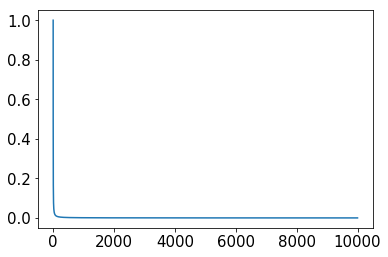

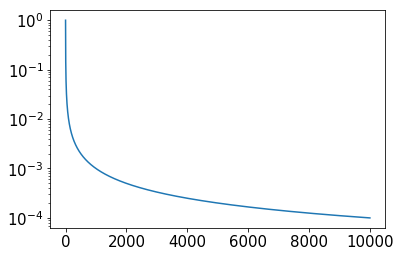

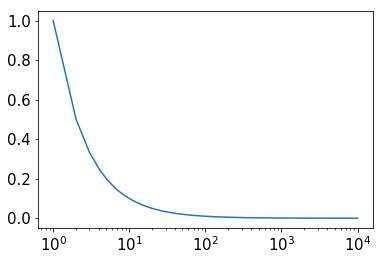

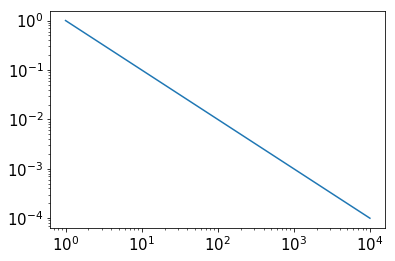

In [917]:
xx = np.arange(10000)+1
yy = 1/xx
plt.plot(xx,yy); plt.show()
plt.semilogy(xx,yy); plt.show()
plt.semilogx(xx,yy); plt.show()
plt.loglog(xx,yy); plt.show()